# Visualisation of a GAN recovering the data distribution

In [22]:
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

from tqdm import tqdm
plt.style.use('dark_background')

In [2]:
class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.tanh(self.fc2(x))
        return self.fc3(x)

class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return F.sigmoid(self.fc3(x))

z_size = 20
G = Generator(z_size, 100, 1)
D = Discriminator(1, 100, 1)

print(G)
print(D)

Generator(
  (fc1): Linear(in_features=20, out_features=100)
  (fc2): Linear(in_features=100, out_features=100)
  (fc3): Linear(in_features=100, out_features=1)
)
Discriminator(
  (fc1): Linear(in_features=1, out_features=100)
  (fc2): Linear(in_features=100, out_features=100)
  (fc3): Linear(in_features=100, out_features=1)
)


In [3]:
def get_distribution_sampler(mu, sigma):
    return lambda n: torch.randn(n)*sigma + mu

def get_noise_sampler():
    return lambda n,m: torch.rand(n,m)

## Unimodal distribution

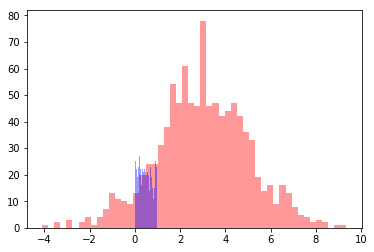

In [4]:
# plot histograms
dsampler = get_distribution_sampler(3, 2)
gsampler = get_noise_sampler()

n = 1000
data_samples = dsampler(n)
noise_samples = gsampler(n,1)[:,0]

bins = 50
plt.hist(data_samples, alpha=0.4, color='r', bins=bins)
plt.hist(noise_samples, alpha=0.4, color='b', bins=bins)
plt.show()

In [5]:
G = Generator(z_size, 100, 1)
D = Discriminator(1, 100, 1)

lr = 1e-3
batch_size = 100
n_epochs = 10000

d_optimiser = optim.SGD(D.parameters(), lr=lr)
g_optimiser = optim.SGD(G.parameters(), lr=lr)

l = []
loss = nn.BCELoss()
zeros = Variable(torch.zeros(batch_size,1))
ones = Variable(torch.ones(batch_size,1))

for epoch in tqdm(range(n_epochs)):
  
    # discriminator training
    for i in range(5):
        D.zero_grad()
        real_data = Variable(dsampler(batch_size).view(-1,1))
        d_real = D(real_data)
        d_real_error = loss(d_real, ones)
        d_real_error.backward()

        z = Variable(gsampler(batch_size, z_size))
        fake = G(z).detach()
        d_fake = D(fake)
        d_fake_error = loss(d_fake, zeros)
        d_fake_error.backward()

        d_optimiser.step()
    
    # generator training
    G.zero_grad()
    gen_data = G(z)
    d_gen = D(gen_data)
    g_error = loss(d_gen, ones)
    g_error.backward()
    g_optimiser.step()
    
    l.append(fake.data.numpy())
    
l = np.array(l)
l = l.reshape(n_epochs,batch_size)

100%|██████████| 10000/10000 [01:34<00:00, 105.97it/s]


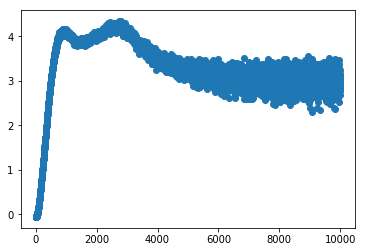

In [6]:
plt.scatter(np.arange(n_epochs), l.mean(axis=1))

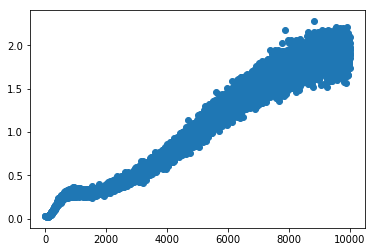

In [7]:
plt.scatter(np.arange(n_epochs), l.std(axis=1))

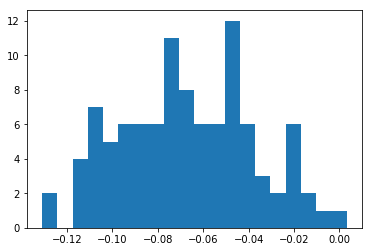

In [8]:
plt.hist(l[0], bins=20)
plt.show()

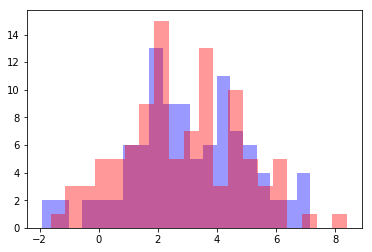

In [9]:
plt.hist(l[-1], bins=20, color='b', alpha=0.4)
plt.hist(np.random.normal(3,2,100), bins=20, color='r', alpha=0.4)
plt.show()

In [25]:
%matplotlib notebook

<IPython.core.display.Javascript object>


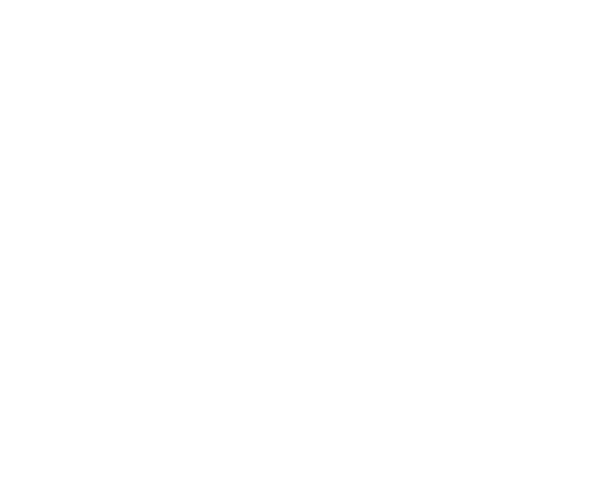

10

In [37]:
fixed = np.random.normal(3,2,100)

def update_hist(num, data):
    plt.cla()
    plt.hist([data[num], fixed], bins=10)
    
number_of_frames = n_epochs

fig = plt.figure(figsize=(6,5))
#hist = plt.hist(l[-1], bins=20, color='b', alpha=0.4)

animation.FuncAnimation(fig, update_hist, number_of_frames, interval=100, fargs=(l, ) )
#plt.show()

## Multimodal distribution

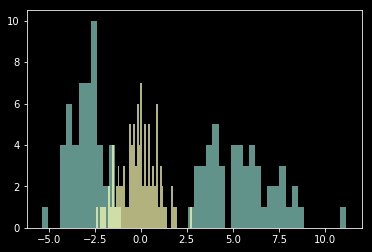

In [39]:
# plot histograms
def sample_z(bs,zs=100):
    return torch.FloatTensor(bs, zs).normal_()

def sample_data(bs):
    half = int(bs/2)
    dist1 = torch.FloatTensor(half, 1).normal_(5,2)
    dist2 = torch.FloatTensor(half, 1).normal_(-3,1)
    return torch.cat([dist1, dist2],0)

bs = 100
x = sample_data(bs)
z = sample_z(bs,1)

bins = 50
plt.hist(x.squeeze(), alpha=0.7, bins=bins)
plt.hist(z.squeeze(), alpha=0.7, bins=bins)
plt.show()

### DCGAN

In [43]:
z_size = 100

G = Generator(z_size, 100, 1)
D = Discriminator(1, 100, 1)

lr = 1e-3
batch_size = 100
n_epochs = 10000

d_optimiser = optim.SGD(D.parameters(), lr=lr)
g_optimiser = optim.SGD(G.parameters(), lr=lr)

l = []
zeros = Variable(torch.zeros(batch_size,1))
ones = Variable(torch.ones(batch_size,1))

criterion = nn.BCELoss()

for epoch in tqdm(range(n_epochs)):
  
    # discriminator training
    D.zero_grad()
    x = sample_data(batch_size)
    x = Variable(x)
    D_real = D(x)
    D_real_error = criterion(d_real, ones)
    
    z = sample_z(batch_size, z_size)
    z = Variable(z)
    fake = G(z).detach()
    D_fake = D(fake)
    D_fake_error = criterion(d_fake, zeros)  
    
    D_err =  D_real_error + D_fake_error
    D_err.backward(retain_graph=True)
    d_optimiser.step()

    # generator training
    G.zero_grad()
    z = sample_z(batch_size, z_size)
    z = Variable(z)
    gen_data = G(z)
    D_gen = D(gen_data)
    G_error = criterion(D_gen, ones)
    
    G_error.backward()
    g_optimiser.step()
    
    l.append(fake.data.numpy())
    
l = np.array(l)
l = l.reshape(n_epochs,batch_size)

  0%|          | 0/10000 [00:00<?, ?it/s]


RuntimeError: Trying to backward through the graph a second time, but the buffers have already been freed. Specify retain_graph=True when calling backward the first time.

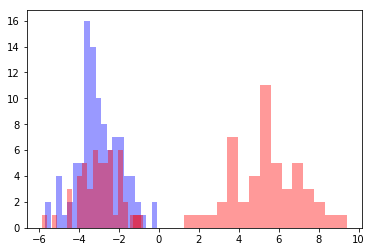

In [12]:
plt.hist(l[-1], bins=20, color='b', alpha=0.4)
plt.hist(np.random.normal(5,2,50), bins=20, color='r', alpha=0.4)
plt.hist(np.random.normal(-3,1,50), bins=20, color='r', alpha=0.4)
plt.show()

### WGAN

In [25]:
class WGenerator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(WGenerator, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.fc3(x)
        return F.tanh(x)

class WDiscriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(WDiscriminator, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        output =  self.fc3(x)
        return output.view(-1,1)

z_size = 20
print(WGenerator(z_size, 100, 1))
print(WDiscriminator(1, 100, 1))

WGenerator(
  (fc1): Linear(in_features=20, out_features=100)
  (fc2): Linear(in_features=100, out_features=100)
  (fc3): Linear(in_features=100, out_features=1)
)
WDiscriminator(
  (fc1): Linear(in_features=1, out_features=100)
  (fc2): Linear(in_features=100, out_features=100)
  (fc3): Linear(in_features=100, out_features=1)
)


In [26]:
G = WGenerator(z_size, 100, 1)
D = WDiscriminator(1, 100, 1)

batch_size = 100
half_bs = int(batch_size/2)

lr = 1e-4
d_optimiser = optim.SGD(D.parameters(), lr=lr)
g_optimiser = optim.SGD(G.parameters(), lr=lr)

l = []
errs = []

clamp = 1e-2

n_epochs = 10000
for epoch in tqdm(range(n_epochs)):
    
    # discriminator training
    for i in range(5):
        for p in D.parameters():
            p.data.clamp_(-clamp, clamp)
            
        D.zero_grad()
        real_data1 = Variable(dsampler1(half_bs).view(-1,1))
        real_data2 = Variable(dsampler2(half_bs).view(-1,1))
        real_data = torch.cat([real_data1, real_data2], 0)
        D_real = D(real_data)
        
        z = Variable(gsampler(batch_size, z_size))
        fake = G(z)
        D_fake = D(fake.detach())
        D_err = torch.mean(D_real) - torch.mean(D_fake)
        D_err.backward()
        d_optimiser.step()
    
    # generator training
    G.zero_grad()
    gen_data = G(z)
    D_fake = D(gen_data)
    G_err = torch.mean(D_fake)
    G_err.backward()
    g_optimiser.step()
    
    errs.append((G_err.data[0], D_err.data[0]))
    l.append(fake.data.numpy())
    
l = np.array(l)
l = l.reshape(n_epochs,batch_size)

100%|██████████| 10000/10000 [01:14<00:00, 134.07it/s]


In [27]:
err_d, err_g = zip(*errs)

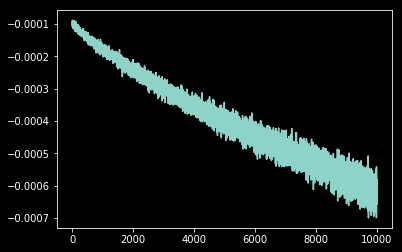

In [28]:
plt.plot(err_g)

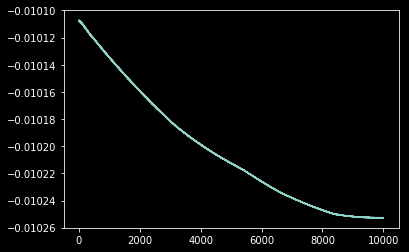

In [29]:
plt.plot(err_d)

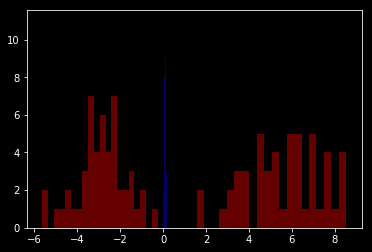

In [30]:
plt.hist(l[-1], bins=20, color='b', alpha=0.4)
plt.hist(np.random.normal(5,2,50), bins=20, color='r', alpha=0.4)
plt.hist(np.random.normal(-3,1,50), bins=20, color='r', alpha=0.4)
plt.show()

In [31]:
z = gsampler(50,100)
z = Variable(z)
gen = G(z).data
plt.hist(gen)

RuntimeError: size mismatch, m1: [50 x 100], m2: [20 x 100] at /opt/conda/conda-bld/pytorch_1513368888240/work/torch/lib/TH/generic/THTensorMath.c:1416

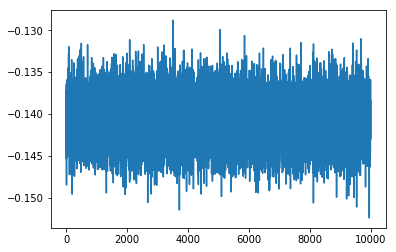

In [21]:
plt.plot(l.mean(axis=1))